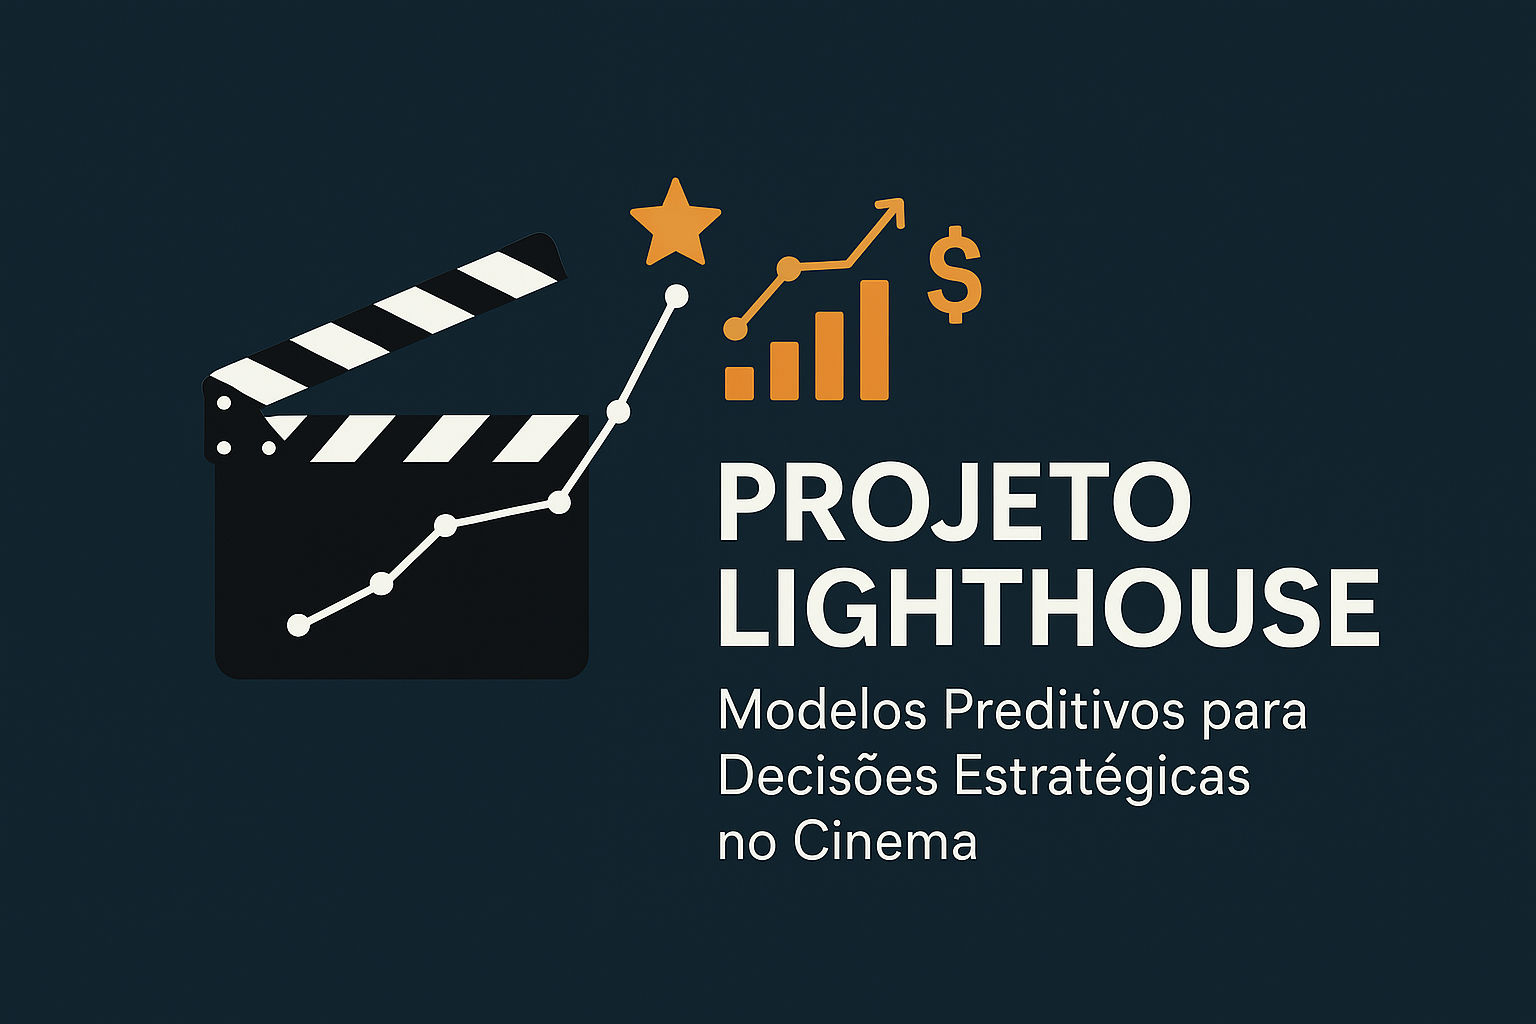

In [1]:
from IPython.display import Image, display
display(Image(filename="img/capa_projeto_lighthouse.png", width=650))

# 1.0 – Contexto do Negócio

* A PProductions é um estúdio global de longas para cinema e streaming.
  * **Receita:** bilheteria, plataformas digitais, licenciamento e merchandising.
  * **Desafios:** alto CAPEX/marketing, competição internacional, mudança do consumo para streaming.
  * **Oportunidade:** usar dados para reduzir incerteza e aumentar a previsibilidade de sucesso.

# 2.0 – Problema & Objetivo

Decidir **qual tipo filme** produzir minimizando risco e maximizando retorno.

Precisamos entender **fatores de sucesso, prever a nota IMDb, avaliar potenciais de faturamento** e usar **NLP** no overview para inferir gêneros.

**Entrega:** EDA objetiva, respostas das hipóteses de negócio e um **modelo de previsão da nota e sinopse** prontos para uso.

# 3.0 – Setup Rápido

In [2]:
# ==== Limites de threads para evitar travamentos ====
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# ==== Imports mínimos ====
import numpy as np, pandas as pd, re, ast
from pathlib import Path
import warnings; warnings.filterwarnings("ignore")
np.random.seed(42)
import joblib, pickle
import sys, sklearn

# ==== Visualização ====
import seaborn as sns
import matplotlib.pyplot as plt

# ==== Modelagem ====
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

# ==== Paths do projeto ====
ROOT = Path(".")
DATA = ROOT / "data"
RAW  = DATA / "raw"
PROC = DATA / "processed"
MODELS = ROOT / "models"
REPORTS = ROOT / "reports"

# Display options
pd.options.display.max_columns = 60
pd.options.display.float_format = "{:.2f}".format

# 4.0 – Funções Auxiliares

In [3]:
def _first_genre(x):
    if isinstance(x, list): 
        return x[0] if x else np.nan
    if pd.isna(x): 
        return np.nan
    s = str(x)
    if s.startswith('['):  # lista salva como string no CSV
        try:
            L = ast.literal_eval(s)
            return L[0] if isinstance(L, list) and len(L) else np.nan
        except Exception:
            pass
    return s.split('|')[0] if '|' in s else s

def _parse_list(s):
    if isinstance(s, list): return s
    if pd.isna(s): return []
    try:
        L = ast.literal_eval(str(s))
        return L if isinstance(L, list) else []
    except Exception:
        return [t.strip() for t in str(s).split("|") if t.strip()]

def _season(m):
    if pd.isna(m): return np.nan
    m = int(m)
    if m in (12,1,2):   return "winter"
    if m in (3,4,5):    return "spring"
    if m in (6,7,8):    return "summer"
    return "fall"

def _eval(Xa, ya):
    yp = pipe.predict(Xa)
    rmse = float(np.sqrt(((ya - yp) ** 2).mean()))
    mae  = float(np.abs(ya - yp).mean())
    r2   = float(1 - ((ya - yp) ** 2).sum() / ((ya - ya.mean()) ** 2).sum())
    return rmse, mae, r2

def build_row_from_lighthouse(movie_dict: dict, required_cols: list[str]) -> pd.DataFrame:
    m = pd.DataFrame([movie_dict]).copy()

    # numéricos/derivadas essenciais
    m['runtime'] = pd.to_numeric(m.get('Runtime','').astype(str).str.extract(r'(\d+)')[0], errors='coerce')
    m['overview'] = m.get('Overview','').astype(str)
    m['overview_len'] = m['overview'].str.len()
    m['vote_count'] = pd.to_numeric(m.get('No_of_Votes', np.nan), errors='coerce')

    gross_clean = m.get('Gross', np.nan)
    if isinstance(gross_clean, pd.Series):
        gross_clean = gross_clean.astype(str).str.replace('[^0-9]','', regex=True)
    m['revenue'] = pd.to_numeric(gross_clean, errors='coerce')
    m['log_revenue'] = np.log1p(m['revenue'])

    m['log_budget'] = np.nan
    m['roi'] = np.nan
    m['original_language'] = 'en'
    m['is_english'] = 1
    m['year'] = pd.to_numeric(m.get('Released_Year', np.nan), errors='coerce')

    genre_str = m.get('Genre','').astype(str)
    m['genre_primary'] = genre_str.str.split(',').str[0].str.strip()
    m['n_genres'] = genre_str.apply(lambda s: len([g for g in s.split(',') if g.strip()]))

    m['n_countries'] = np.nan
    m['popularity']  = np.nan
    m['mean_rating'] = np.nan
    m['num_ratings'] = m['vote_count']
    m['release_season'] = 'fall'

    m['director'] = m.get('Director','').astype(str)
    m['star1'] = m.get('Star1','').astype(str)
    m['star2'] = m.get('Star2','').astype(str)
    m['star3'] = m.get('Star3','').astype(str)
    m['star4'] = m.get('Star4','').astype(str)

    row = pd.DataFrame([{c: np.nan for c in required_cols}])
    for c in required_cols:
        if c in m.columns:
            row[c] = m[c].iloc[0]
    return row

# 5.0 – Carregamento dos Dados

In [4]:
df = pd.read_csv(PROC / "kaggle_otimizado.csv", low_memory=False)

print("kaggle_otimizado:", df.shape)

df.head(3)

kaggle_otimizado: (45411, 21)


,budget,imdb_id,original_language,overview,popularity,release_date,revenue,runtime,vote_average,vote_count,director,star1,star2,star3,star4,mean_rating,num_ratings,original_title_norm,year,countries_names,genres_list
0,160000000.00,tt1375666,en,"Cobb, a skilled thief who commits corporate es...",29.11,2010-07-14,825532764.00,148.00,8.10,14075.00,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Ellen Page,Tom Hardy,4.16,35297.00,inception,2010.00,"['United Kingdom', 'United States of America']","['Action', 'Thriller', 'Science Fiction', 'Mys..."
1,185000000.00,tt0468569,en,Batman raises the stakes in his war on crime. ...,123.17,2008-07-16,1004558444.00,152.00,8.30,12269.00,Christopher Nolan,Christian Bale,Michael Caine,Heath Ledger,Aaron Eckhart,4.18,39600.00,the dark knight,2008.00,"['United Kingdom', 'United States of America']","['Drama', 'Action', 'Crime', 'Thriller']"
2,237000000.00,tt0499549,en,"In the 22nd century, a paraplegic Marine is di...",185.07,2009-12-10,2787965087.00,162.00,7.20,12114.00,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,Stephen Lang,3.66,21924.00,avatar,2009.00,"['United States of America', 'United Kingdom']","['Action', 'Adventure', 'Fantasy', 'Science Fi..."


# 6.0 – Features Essenciais

## 6.1 – Engenharia e Seleção de Atributos

In [5]:
# Texto
df["overview"] = df.get("overview", "").astype(str)
df["overview_len"] = df["overview"].str.len()

# Datas → ano e estação
if "release_date" in df.columns:
    df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
    df["release_month"] = df["release_date"].dt.month
    df["release_season"] = df["release_month"].map(_season)
if "year" not in df.columns and "release_date" in df.columns:
    df["year"] = df["release_date"].dt.year

# Numéricos base
for c in ["budget","revenue","runtime","popularity","vote_count","mean_rating","num_ratings","vote_average","year"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Transformações
if "budget" in df.columns:
    df["log_budget"] = np.log1p(df["budget"].clip(lower=0))
if "revenue" in df.columns:
    df["log_revenue"] = np.log1p(df["revenue"].clip(lower=0))
if {"budget","revenue"}.issubset(df.columns):
    df["roi"] = df["revenue"] / df["budget"].replace({0: np.nan})

# Gêneros e países (contagens + gênero principal)
if "genres_list" in df.columns:
    gl = df["genres_list"].apply(_parse_list)
    df["n_genres"] = gl.map(len)
    df["genre_primary"] = gl.map(lambda L: L[0] if L else np.nan)

if "countries_names" in df.columns:
    cn = df["countries_names"].apply(_parse_list)
    df["n_countries"] = cn.map(len)

# Idioma principal
if "original_language" in df.columns:
    df["is_english"] = (df["original_language"].astype(str) == "en").astype(int)

# Garantir dtype categórico/objeto nas categóricas
for c in ["original_language","release_season","genre_primary","director","star1","star2","star3","star4"]:
    if c in df.columns:
        df[c] = df[c].astype("object")

created = [c for c in ["log_budget","log_revenue","roi","runtime","popularity","vote_count",
                        "mean_rating","num_ratings","overview_len","year","n_countries",
                        "n_genres","is_english","release_season","genre_primary",
                        "director","star1","star2","star3","star4"] if c in df.columns]
print("Features prontas:", created)

# ===== Seleção de colunas para H11 =====
y = pd.to_numeric(df["vote_average"], errors="coerce")

num_cols = [c for c in ["log_budget","log_revenue","roi","runtime","popularity","vote_count",
                        "mean_rating","num_ratings","overview_len","year","is_english",
                        "n_countries","n_genres"] if c in df.columns]
cat_cols = [c for c in ["original_language","release_season","genre_primary",
                        "director","star1","star2","star3","star4"] if c in df.columns]
txt_col  = "overview" if "overview" in df.columns else None

use_cols = num_cols + cat_cols + ([txt_col] if txt_col else [])
X = df[use_cols].copy()
mask = y.notna()
X, y = X.loc[mask], y.loc[mask]

print("X:", X.shape, "| y:", y.shape)

Features prontas: ['log_budget', 'log_revenue', 'roi', 'runtime', 'popularity', 'vote_count', 'mean_rating', 'num_ratings', 'overview_len', 'year', 'n_countries', 'n_genres', 'is_english', 'release_season', 'genre_primary', 'director', 'star1', 'star2', 'star3', 'star4']
X: (45406, 22) | y: (45406,)


# 7.0 – EDA

## 7.1 – Medidas por gênero

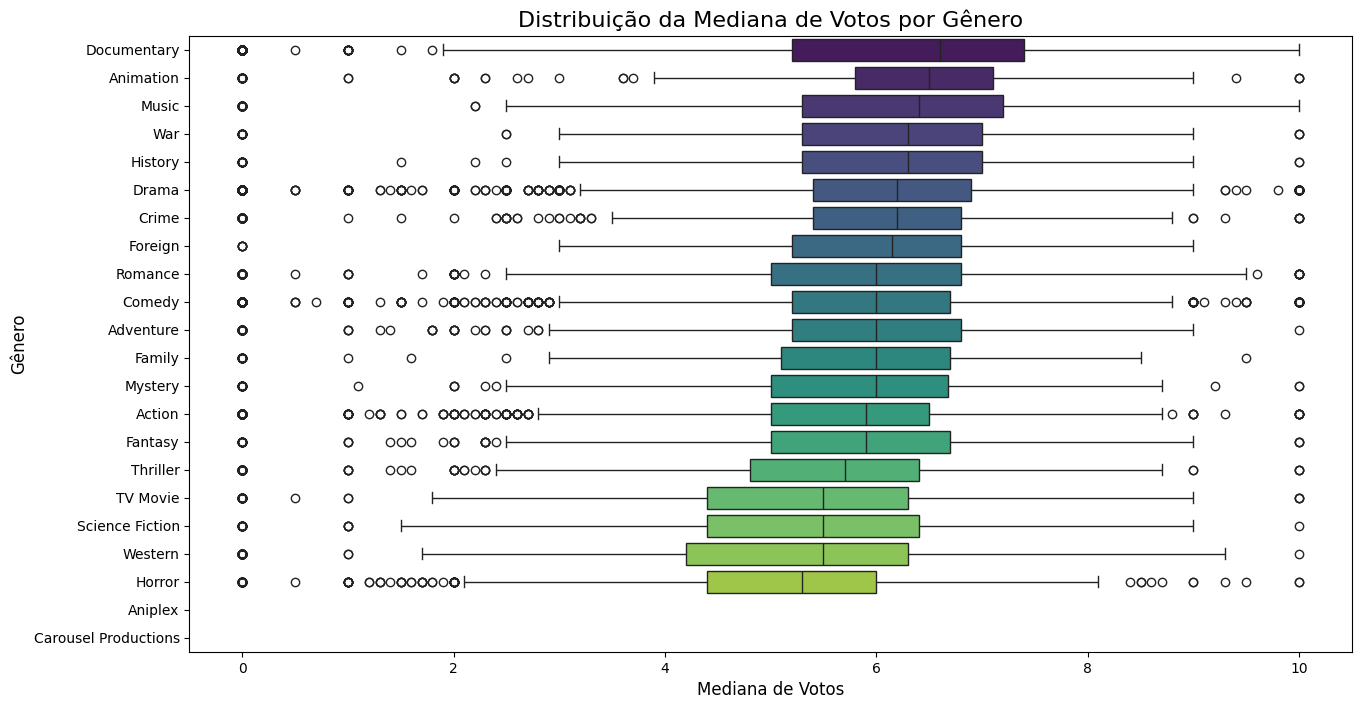

In [6]:
# ===== Gráfico por gênero =====
if "genre_primary" in df.columns and "vote_average" in df.columns:
    eda_order = (df.groupby("genre_primary")["vote_average"]
                   .median()
                   .sort_values(ascending=False)
                   .index)

    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df, 
                x="vote_average", 
                y="genre_primary", 
                order=eda_order,
                palette="viridis")
    
    plt.title('Distribuição da Mediana de Votos por Gênero', fontsize=16)
    plt.xlabel('Mediana de Votos', fontsize=12)
    plt.ylabel('Gênero', fontsize=12)
    plt.show()

else:
    print("Colunas necessárias não encontradas para o gráfico por gênero.")

## 7.2 – Correlação numérica

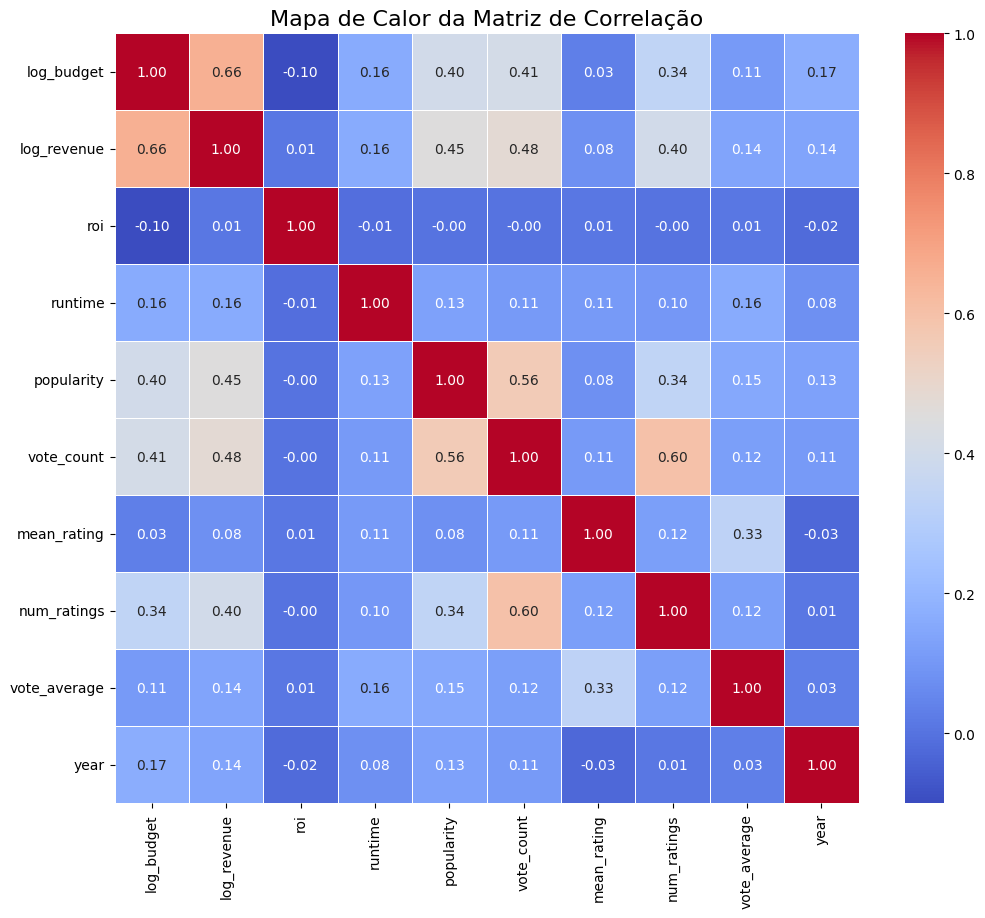

In [7]:
# ===== Matriz de Correlação =====
cols_corr = [c for c in ["log_budget", "log_revenue", "roi", "runtime",
                        "popularity", "vote_count", "mean_rating",
                        "num_ratings", "vote_average", "year"]
            if c in df.columns]

if len(cols_corr) >= 2:
    corr = df[cols_corr].corr(numeric_only=True).round(2)

    plt.figure(figsize=(12, 10))  
    sns.heatmap(corr, 
                annot=True,     
                cmap='coolwarm',
                fmt=".2f",     
                linewidths=.5)  
    
    plt.title('Mapa de Calor da Matriz de Correlação', fontsize=16)
    plt.show()  
else:
    print("Poucas colunas numéricas disponíveis para correlação.")

# 8.0 – Hipóteses de Negócio H1-H8

## 8.1 – Quadro Compacto

In [8]:
# ===== Hipóteses de Negócio =====
try:
    hypo_df = pd.read_csv(REPORTS / "hypotheses_summary.csv")
except Exception:
    hypo_df = pd.DataFrame([
    {"H": "H1", "Hipótese": "Orçamento ↑ → Receita ↑", 
     "Veredito": "Parcialmente verdadeira", "Insight": "↑ receita, não garante ROI"},
    {"H": "H2", "Hipótese": "Popularidade antecipa bilheteria", 
     "Veredito": "Verdadeira", "Insight": "Bom indicador inicial de $$$"},
    {"H": "H3", "Hipótese": "Nota IMDb ↑ → Receita ↑", 
     "Veredito": "Falso", "Insight": "Melhora longevidade, não garante bilheteria"},
    {"H": "H4", "Hipótese": "Filmes muito longos penalizam a nota", 
     "Veredito": "Falso", "Insight": "Fraca correlação"},
    {"H": "H5", "Hipótese": "Certos gêneros retornam mais", 
     "Veredito": "Parcialmente verdadeira", "Insight": "Diferenças por mediana; alta dispersão"},
    {"H": "H6", "Hipótese": "Diretor/elenco elevam receita/ROI", 
     "Veredito": "Parcialmente verdadeira", "Insight": "Fama ↑ receita; ROI depende de custo"},
    {"H": "H7", "Hipótese": "Filme p/ desconhecido", 
     "Veredito": "Verdadeira", "Insight": "Alta nota + muitos votos (consenso)"},
    {"H": "H8", "Hipótese": "Época influencia receita", 
     "Veredito": "Verdadeira", "Insight": "Mediana cai pós-2010; engajamento ↑"},
])
display(hypo_df)

,H,Hipótese,Veredito,Insight
0,H1,Orçamento ↑ → Receita ↑,Parcialmente verdadeira,"↑ receita, não garante ROI"
1,H2,Popularidade antecipa bilheteria,Verdadeira,Bom indicador inicial de $$$
2,H3,Nota IMDb ↑ → Receita ↑,Falso,"Melhora longevidade, não garante bilheteria"
3,H4,Filmes muito longos penalizam a nota,Falso,Fraca correlação
4,H5,Certos gêneros retornam mais,Parcialmente verdadeira,Diferenças por mediana; alta dispersão
5,H6,Diretor/elenco elevam receita/ROI,Parcialmente verdadeira,Fama ↑ receita; ROI depende de custo
6,H7,Filme p/ desconhecido,Verdadeira,Alta nota + muitos votos (consenso)
7,H8,Época influencia receita,Verdadeira,Mediana cai pós-2010; engajamento ↑


# 9.0 – Previsão da nota IMDb

## 9.1 – Carregando o Modelo

In [9]:
# Aceita .pkl como dict ou pipeline
model_path = MODELS / "h11_imdb_rating_model.pkl"

def _load_model(p):
    try:
        return joblib.load(p)
    except Exception:
        with open(p, "rb") as f:
            return pickle.load(f)

obj = _load_model(model_path)
print("Carregado:", model_path, "| tipo:", type(obj))

# Desempacota se for dict (procura uma chave com .predict)
if isinstance(obj, dict):
    for key in ("pipe","pipeline","model","estimator"):
        if key in obj and hasattr(obj[key], "predict"):
            pipe = obj[key]
            break
    else:
        raise TypeError("O .pkl contém um dict sem objeto com .predict (esperei chaves como 'pipe'/'pipeline').")
else:
    pipe = obj

if not hasattr(pipe, "predict"):
    raise TypeError(f"Objeto carregado não tem .predict: {type(pipe)}")

print("Pipeline pronto para inferência!")

Carregado: models/h11_imdb_rating_model.pkl | tipo: <class 'dict'>
Pipeline pronto para inferência!


## 9.1 – Previsão - The Shawshank

In [10]:
# Descobrindo colunas exigidas pelo pipeline
try:
    required_cols = list(pipe.feature_names_in_)
except Exception:
    prep = getattr(pipe, "named_steps", {}).get("prep", None)
    if prep is None:
        raise RuntimeError("Pipeline não possui etapa 'prep' (ColumnTransformer).")
    required_cols = []
    for name, transf, cols in prep.transformers_:
        if cols in (None, 'drop'):
            continue
        if isinstance(cols, (list, tuple, pd.Index, np.ndarray)):
            required_cols.extend([str(c) for c in cols])
        else:
            required_cols.append(str(cols))
    required_cols = sorted(pd.unique(required_cols))

# Dicionário do enunciado
movie = {
 'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'
}

# Monta a linha com as colunas esperadas pelo pipeline
x_new = build_row_from_lighthouse(movie, required_cols)

# Garante dtype objeto nas categóricas comuns
for c in ['original_language','release_season','genre_primary','director','star1','star2','star3','star4']:
    if c in x_new.columns:
        x_new[c] = x_new[c].astype('object').fillna('UNK')

# Prediz pelo pipeline
pred = float(pipe.predict(x_new)[0])
print(f"Previsão IMDb (Shawshank): {pred:.2f}")


Previsão IMDb (Shawshank): 6.34


In [11]:
# Real vs. Previsto - Erro absoluto
IMDB_ID = "tt0111161"
if "imdb_id" in df.columns:
    m = df["imdb_id"].astype(str).eq(IMDB_ID)
else:
    m = df["original_title_norm"].astype(str).str.contains("shawshank", case=False, na=False)

cols = [c for c in ["vote_average","vote_count"] if c in df.columns]
cand = df.loc[m, cols].dropna(subset=["vote_average"])
if len(cand):
    if "vote_count" in cand.columns:
        cand = cand.sort_values("vote_count", ascending=False)
    real = float(cand["vote_average"].iloc[0])
    print(f"Real: {real:.2f} | Previsto: {pred:.2f} | Erro abs.: {abs(real - pred):.2f}")
else:
    print("Nota real não encontrada no dataset.")

Real: 8.50 | Previsto: 6.34 | Erro abs.: 2.16


# 10.0 – Respostas & Conclusão

## 10.1 - Respostas ao Desafio

1) **Filme recomendado p/ desconhecido**  
   Recomendar títulos com **alta nota** e **muitos votos** (consenso social).

2) **Fatores ligados a alta receita/retorno**  
   - **Orçamento** → eleva **receita bruta** (não garante ROI).  
   - **Popularidade/engajamento** → bom *leading indicator* de performance comercial.  
   - **Gênero**: **Animation/Family/Adventure** lideram **receita**; **Horror/Crime/Mystery** se destacam em **ROI** (custo menor).  
   - **Talentos** e **janela/sazonalidade** contribuem, mas o **ROI** depende do **mix** (custo × apelo).  

3) **Overview → Gênero (H9)**  
   O texto traz **sinal semântico** — é viável **inferir gêneros** via modelo **multirrótulo**.  
   *Modelo salvo*: `models/h9_multilabel_pipeline.joblib`.

4) **Previsão da nota IMDb (H11)**  
   Problema de **regressão**; pipeline **TF-IDF (overview) + One-Hot (cats) + numéricos (logs/ROI)**.  
   **HGB / RF** foram os melhores; métricas: **RMSE/MAE/R²**.  
   *Nota do exemplo (Shawshank)*: **≈ 6,3** vs **8,5** (dataset).  
   *Modelo salvo*: `models/h11_imdb_rating_model.pkl`.

5) **Entrega**  
   `README`, `requirements.txt`, relatórios (PDF/Notebook), códigos de modelagem e artefatos `.pkl`/`.joblib`.


## 10.2 - Principais Achados (EDA → Negócios)

- **H1** Orçamento ↑ = Receita ↑ (**⚠️ parcial**): sobe a receita bruta; **ROI** não garantido.
  
- **H2** Popularidade antecipa bilheteria (**✅**): bom *leading indicator*.
  
- **H3** Nota IMDb ↑ = Receita ↑ (**❌**): ajuda longevidade/atração, não garante bilheteria.
  
- **H4** Runtime alto (>150m) → efeito na nota (**⚠️ fraco/indefinido**): evidência não robusta.
  
- **H5** Gênero importa (**✅com nuances**): **Animation/Family/Adventure** sustentam **receita e consistência**, mas exigem **alto orçamento** (ROI moderado); gêneros de **baixo custo** como **Horror/Crime/Mystery** tendem a **maior ROI**, porém **mais voláteis**. ⇒ A escolha depende do objetivo (**receita × ROI × prestígio**).
  
- **H6** Diretor/Elenco ajudam receita (**⚠️ parcial**); **ROI** depende do custo.
  
- **H7** Recomendação p/ desconhecido (**✅**): **alta nota + muitos votos** (ex.: *DDLJ* (1995), *Shawshank* (1994)).
  
- **H8** Pós-2010 (**✅**): **engajamento ↑**, **mediana de receita ↓** (fragmentação/streaming).

| Objetivo | Gêneros foco | Justificativa |
|---|---|---|
| Receita bruta | Animation / Family / Adventure | Altíssimo alcance global; medianas de receita mais altas. |
| ROI | Horror / Crime / Mystery (+ Animation/Family p/ estabilidade) | Custos menores → melhor retorno proporcional; controle de risco com gêneros estáveis. |
| Prestígio | Animation / Crime / Mystery | Notas/qualidade técnica e narrativas valorizadas pela crítica. |


# 11.0 – Conclusões & Próximos passos

## 11.1 - Próximos Passos
- **Comparação de bases**: treinar/avaliar H11 também na **base enriquecida Lighthouse** e comparar.

- **Refatoração**: reorganizar funções/notebooks em `src/` para reuso e clareza.

- **H9 (texto → gêneros)**: elevar **F1-micro em ≥3–5 p.p.** e **F1-macro em ≥2–3 p.p.** via  
  * (i) TF-IDF `max_features` maior / **embeddings**;  
  * (ii) calibração de **threshold/Top-K**;  
  * (iii) **balanceamento** por classe.
  
- **H11 (regressão)**: **reduzir o RMSE em ≥20%** e **elevar o R² em +0.03–0.05** com  
  * (i) top-K maior p/ `director`/`stars`;  
  * (ii) nova feature `decade`;  
  * (iii) TF-IDF mais rico e/ou **blending** com modelo só-texto.
  
- **ROI por mix**: avaliar **gênero × orçamento × janela × elenco** (uplift simples).
  
- **Explicabilidade**: exportar **importâncias/SHAP** para o relatório técnico.


## 11.2 - Como prevemos a nota do IMDb

- **Tipo de problema**: **Regressão supervisionada** (alvo: `vote_average` no range [0,10]).
  
- **Variáveis/transformações**:  
  - **Numéricas**: `log_budget`, `log_revenue`, `roi`, `runtime`, `popularity`, `vote_count`, `mean_rating`, `num_ratings`, `overview_len`, `year` (logs suavizam escala; ROI captura eficiência).  
  - **Categóricas** (top-K + “Other”): `original_language`, `release_season`, `genre_primary`, `director`, `star1..4` (controla cardinalidade).  
  - **Texto**: `overview` → **TF-IDF (1–2-gram)** para sinal semântico.

- **Modelos testados**: Linear/Ridge/ElasticNet vs **Random Forest / HistGradientBoosting**.  
  
- **Melhor ajuste**: **HGB/RF** (capturam **não-linearidades** e **interações**).  
  - **Prós**: robustos ao *mix* num+cat+texto; boa performance.  
  - **Contras**: menos interpretáveis que lineares; sensíveis a *preprocessing* e cardinalidade.  
  
- **Métricas**: **RMSE** (erro médio em pontos de nota), **MAE** e **R²** (variância explicada).  
  - **Por quê RMSE**: penaliza mais erros grandes, útil para priorização/risco.


# 12.0 - Versões do Ambiente

In [12]:
# Versões dos pacotes
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__, "| numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)

Python: 3.10.14
pandas: 2.3.2 | numpy: 2.2.6
scikit-learn: 1.7.1
